In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("./jena_climate_2009_2016.csv")

In [4]:
# 1. First convert the DataFrame to a CSV string
csv_text = data.to_csv(index=False)

# 2. Now split like you wanted
lines = csv_text.split("\n")
header = lines[0].split(",")
lines = lines[1:]  # remove the header line

# 3. Print results
print(header)
print(len(lines))

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
420552


In [5]:
lines = [line for line in lines if line.strip()]
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Ploting the first 10 days of the temperature timeseries

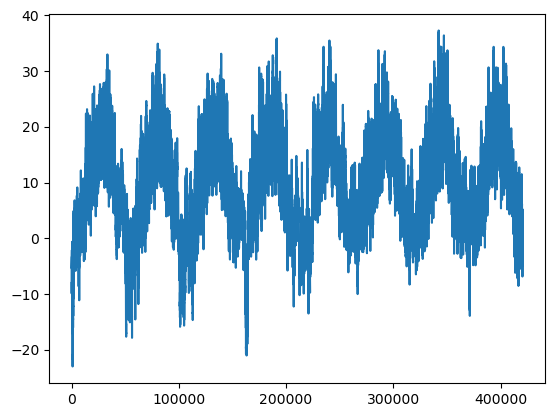

In [6]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

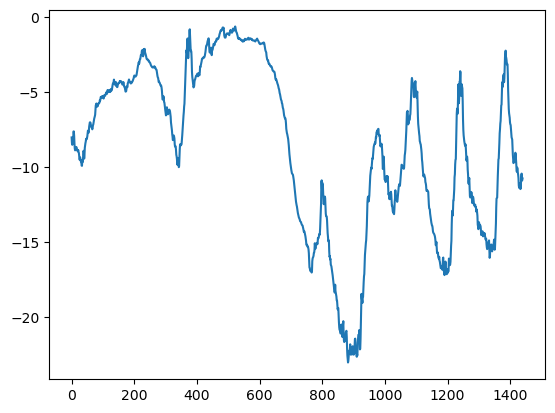

In [7]:
plt.plot(range(1440), temperature[:1440])

Computing the number of samples we'll use for each data split

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_sample:", num_train_samples)
print("num_val_sample:", num_val_samples)
print("num_test_sample:", num_test_samples)

num_train_sample: 210275
num_val_sample: 105137
num_test_sample: 105139


Preparing data 

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

time_series_dataset_from_array() .The general idea is that you provide an array of timeseries data , data in a sequence 


In [10]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3], targets=int_sequence[3:], sequence_length=3, batch_size=2
)
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2025-05-16 11:39:29.640870: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Instantiating datasets for training , validation , testing

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=0,
end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_train_samples + num_val_samples
)

inspecting the output of one of our datasets 

In [12]:
for samples,targets in train_dataset:
    print("sample shape:", samples.shape)
    print("Target shape:",targets.shape)
    break

sample shape: (256, 120, 14)
Target shape: (256,)


Computing the common-sense baseline MAE

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err =0.
    samples_seen =0
    for samples, targets in dataset:
        preds = samples[:,-1,1]*std[1]+mean[1]
        total_abs_err +=np.sum(np.abs(preds-targets))
        samples_seen+=samples.shape[0]
    return total_abs_err/samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2025-05-16 11:39:33.904525: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44
Test MAE: 2.62


Training and evaluating a densely connected model 

In [16]:
import tensorflow as tf


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  # shape: (120, 14)
x = tf.keras.layers.GlobalAveragePooling1D()(inputs)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 14)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 87.4825 - mae: 7.4088 - val_loss: 22.3748 - val_mae: 3.7214
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 22.8179 - mae: 3.8134 - val_loss: 20.6634 - val_mae: 3.6016
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 21.9863 - mae: 3.7428 - val_loss: 20.5323 - val_mae: 3.5871
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 21.8789 - mae: 3.7337 - val_loss: 20.5487 - val_mae: 3.5850
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 21.7463 - mae: 3.7225 - val_loss: 20.7422 - val_mae: 3.6072
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 21.6507 - mae: 3.7139 - val_loss: 20.5607 - val_mae: 3.5854
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 21.5795 - mae: 3.7063 - val_loss: 20.6962 - val_mae: 3.5951
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 21.5325 - mae: 3.7024 - val_loss: 20.6301 - val_mae: 3.5878
Epoch 9/10
819/819 ━━━━━

In [18]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 790.7257 - mae: 6.0641
Test MAE: 6.08


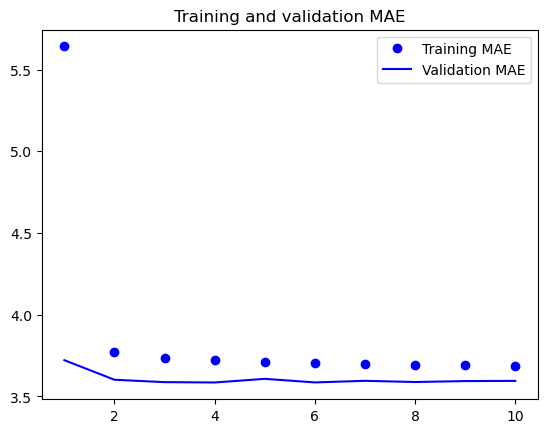

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

1D convolutional model

In [20]:
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = tf.keras.layers.Conv1D(8,24,activation="relu")(inputs)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Conv1D(8,24,activation="relu")(x)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Conv1D(8,6,activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs,outputs)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("jena_conv1d.keras",save_best_only=True)
]
model.compile(optimizer="rmsprop",loss="mse",metrics=["mse"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks
                    )
model= tf.keras.models.load_model("jena_conv1d.keras")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 32.2184 - mse: 32.2184 - val_loss: 13.7866 - val_mse: 13.7866
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 14.2796 - mse: 14.2796 - val_loss: 13.4306 - val_mse: 13.4306
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 12.9521 - mse: 12.9521 - val_loss: 12.7673 - val_mse: 12.7673
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 12.0807 - mse: 12.0807 - val_loss: 13.6300 - val_mse: 13.6300
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 11.4187 - mse: 11.4187 - val_loss: 12.6878 - val_mse: 12.6878
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 10.7702 - mse: 10.7702 - val_loss: 13.4898 - val_mse: 13.4898
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 10.3844 - mse: 10.3844 - val_loss: 13.6374 - val_mse: 13.6374
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 10.0458 - mse: 10.0458 - val_loss: 12.5133 - val_mse: 12.5133
Epoch 9/

In [21]:
print(f"Test MAE:{model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 23253.7754 - mse: 23253.7754
Test MAE:23429.12


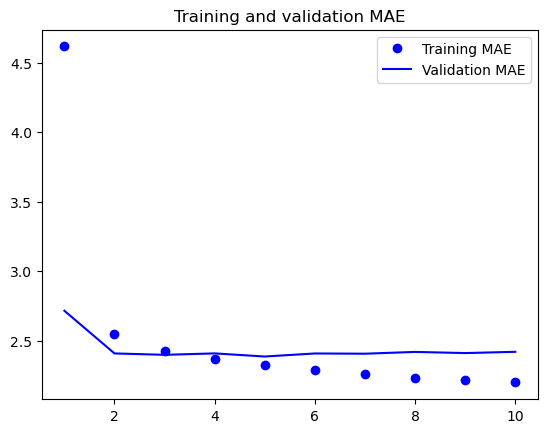

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### First recurrent baseline

In [26]:
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs,outputs)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("jena_Lstm.keras",save_best_only=True)
]

model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


model = tf.keras.models.load_model("jena_Lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 71.5458 - mae: 6.4133 - val_loss: 12.7612 - val_mae: 2.7158
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 11.4324 - mae: 2.6199 - val_loss: 9.5754 - val_mae: 2.4088
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 9.7530 - mae: 2.4379 - val_loss: 9.4722 - val_mae: 2.3987
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - loss: 9.3078 - mae: 2.3767 - val_loss: 9.5722 - val_mae: 2.4090
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - loss: 8.9750 - mae: 2.3317 - val_loss: 9.3543 - val_mae: 2.3866
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 8.6774 - mae: 2.2962 - val_loss: 9.6410 - val_mae: 2.4085
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 8.4591 - mae: 2.2677 - val_loss: 9.5008 - val_mae: 2.4068
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 8.2571 - mae: 2.2382 - val_loss: 9.6539 - val_mae: 2.4197
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

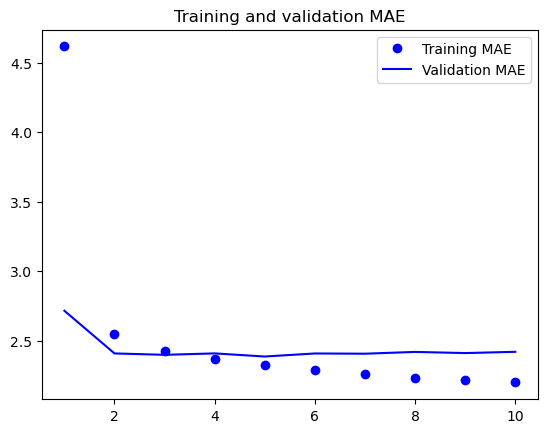

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Numpy Implementation of a simple RNN

In [29]:
timesteps = 100
input_features = 32
output_features = 64
inputs= np.random.random((timesteps,input_features))
state_t = np.zeros((output_features,))
W= np.random.random((output_features,input_features))
U = np.random.random((output_features,output_features))
b= np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W,input_t)+np.dot(U,state_t)+b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs,axis=0)

In [30]:
print(final_output_sequence)

[[0.99999942 0.99999999 0.99999997 ... 1.         0.99999951 1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [32]:
inputs = tf.keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x=tf.keras.layers.LSTM(32,recurrent_dropout=0.25)(inputs)
x= tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs,outputs)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("jenn_lstm_dropout.keras",save_best_only=True)
]

model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data = val_dataset,
                    callbacks=callbacks
                    )


Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 55.1404 - mae: 5.5198 - val_loss: 9.5965 - val_mae: 2.4036
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 15.3806 - mae: 3.0456 - val_loss: 9.2876 - val_mae: 2.3775
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 14.5274 - mae: 2.9577 - val_loss: 9.1563 - val_mae: 2.3623
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 13.9640 - mae: 2.9007 - val_loss: 9.0381 - val_mae: 2.3440
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 13.4311 - mae: 2.8451 - val_loss: 9.1278 - val_mae: 2.3508
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 13.1352 - mae: 2.8171 - val_loss: 9.2064 - val_mae: 2.3586
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 12.9081 - mae: 2.7882 - val_loss: 8.8959 - val_mae: 2.3171
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 12.6360 - mae: 2.7624 - val_loss: 8.9832 - val_mae: 2.3273
Epoch 9/50
819/819 ━━━━━━━━━━━━━

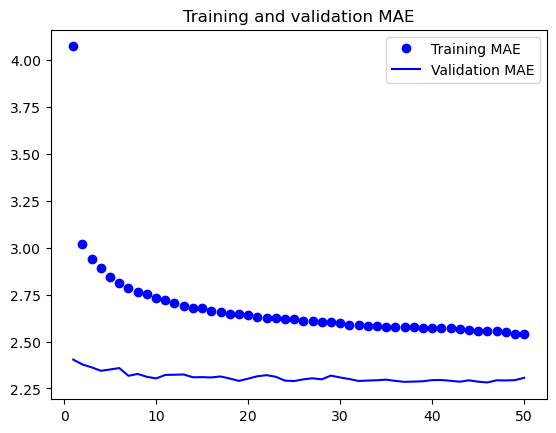

In [33]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()